# Introduction to Artificial Neural Networks

The following is an annotated walk-through of the creation of an artificial neural network, from scratch following the lecture by Andrej Karpathy on the development of "Micrograd." The result is a fully functional feed-forward MLP (Multilayer Perceptron) neural network. This engine is simple in the way that it operates on scalar-value inputs rather than vector or tensor inputs. As such, the gradient vectors per neuron will be one-dimensional. Nonetheless, the following network will still be capable of performing simple binary classification tasks.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# minor untilities for convenience
from varname import varname

# 0: Basic Calulus Review

The principal learning algorithm we will use to train this network relies heavily on principles of caluclus. Calculus in many ways formalizes the study of the fundamental principles governing change between values. Quantifying these relationships between values will directly inform us of how values in our network relate to the network's final output, as we will see.

In [2]:
# Example 1-dimensional function
def f(x):
    return 5*x**2 +6*x -5

In [3]:
f(3.0)

58.0

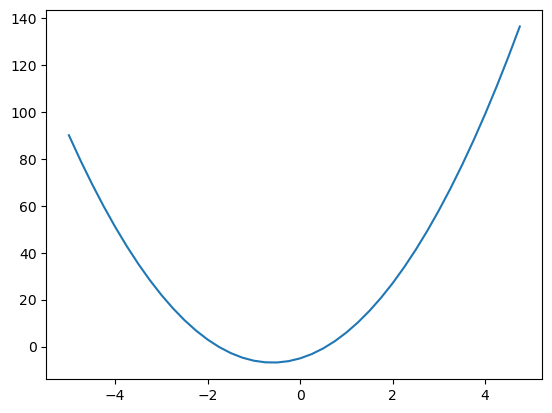

In [4]:
# Plotting the function for the specified range
x_range = np.arange(-5, 5, 0.25)
ys_over_x_range = f(x_range)
plt.plot(x_range, ys_over_x_range)

In [5]:
## calculating as close to a continuous rate of change, or derivative, as we can for y with resepct to x
## Our use of this principle will be in a multivariable environment

h = 0.000000001
x = -1.8/3
slope = (f(x + h) - f(x)) / h
slope

0.0

# 1: Creating Micrograd

The foundation of the Micrograd engine is the Value object. The value object holds a quantitative value, as well as operations through which mathematical functions can be performed between value objects.

What makes value objects special is their ability to hold reference to the objects that came before it in a sequence of operations, as well as knowledge of the nature of the operation itself.

This connected chain of Value objects is called the "computation graph," and by propagating backwards through the computation graph, we can calculate the gradient of each value object with respect to the final node in the graph using the fundamental formulas for calulating derivatives.

These partial derivatives will be essential for tuning the network parameters during the learning phase.


In the context of a neural network, we will see how can can use combinations of Value objects in order to construct a mathematical model of a "neuron."

In [6]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 0.0;
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        try:
            if label == "":
                self.label = varname()
            else:
                self.label = label
        except:
            self.label = label
    
    def varname(self):
        try:
            out = varname(frame = 2)
            return out
        except:
            return " "


    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+', self.varname())
        
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        out = self + other
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*', self.varname())
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # other * self
        out = self * other
        return out
    
    def __neg__(self): # -self
        out = self * -1
        return out
    
    def __sub__(self, other): # self - other
        neg = -other
        out = self + neg
        return out
    
    def __rsub__(self, other): # other - self
        out = self - other
        return out
    
    def __truediv__(self, other): # self / other
        pow = other**-1
        out = self * pow
        return out
    
    def __rtruediv__(self, other): # other / self
        temp = Value(other) ; temp.label = ""
        out = temp / self
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh', self.varname())
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp', self.varname())
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}', self.varname())
        
        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        # Topological sort the expression nodes
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        # Perform backpropagation
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


### Graph Visualization Code to Visualize Micrograd Networks:

In [7]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'}) #LR = left to right
    
    nodes1, edges1 = trace(root)
    for n in nodes1:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = '{ %s | data %.4f | grad %.4f}' %  (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if this value is the result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2, in edges1:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot    

# 2: Value Objects as a Multivariable Expression

Using the functionality of the Value object, we can now perform mathematical operations between them, while simultaneously constructing the computation graph.

In [8]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
e = a * b
d = e + c

f = Value(-2.0)
L = d * f

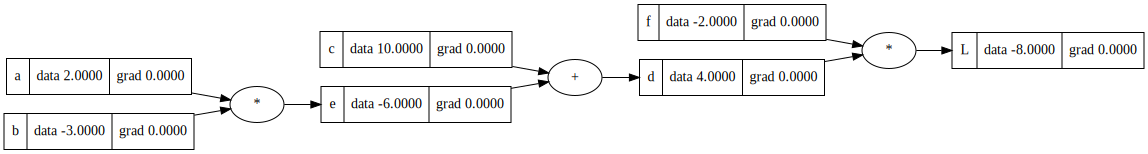

In [9]:
draw_dot(L)

# 3: Manual Backpropagation: Calculating the Gradient 

### What is Backpropagation?

Backpropagation is a learning algorithm that is essential towards training the network towards a desired output. Through backpropagation we can determine exactly how each parameter in a network affects the amount of error the network produces relative to the desired output.

In other words, each parameter of each neuron will have a quantifiable influence on the final output of the network, and this influence can be calculated as the rate of change, or partial derivative, of that parameter with respect to the network's calculated deviance from it's expected output (network error, which will be covered later).

These derivatives are called gradients, and the "gradient field" of the function with respect to the network error represents the rate of change of each parameter in the n-dimensional space. In this gradient field is where our parameters would like to converge towards a relative minimum, at which point the network error will approximate towards zero error, representing accurate predictions from the network.

The points in this field represent the direction change each parameter should take to reach this minimum. Since Micrograd operates on scalars, these vectors are one-dimensional.

### Applying Gradients to Adjust Values in an Expression

Below, we can see how a Value's data can be added by it's gradient multiplied by a step size in order to adjust the data towards a meaningful direction with respect to which object the gradient was taken with respect to.

In [10]:
# By knowing the direction of the gradient, we have an understanding that can help us control the direction of the output
# We can increase the leaf nodes by a small amount multiplied by the gradient, gaining its direction, to increase the output
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b;
d = e + c;
L = d * f;

print(L.data)

-8.0


In [11]:
# Manual Back Propagation Calculations
b.grad = -4
a.grad = 6

In [12]:
c.grad = -2
e.grad = -2

In [13]:
f.grad = 4

In [14]:
d.grad = -2

In [15]:
L.grad = 1.0

# 4:  Creating a Neuron from Value Objects

## The Anatomy Of a Neuron

As conceived by Warren McCulloch and Walter Pitts in 1943, the state of a neuron (its activation state) is "factually equivalent to a proposition which proposed its adequate stimulus."

In other words, a neuron is a generalized, atomic-level reasoning instrument capable of creating an adequate output with repsect to its given inputs, under the condition that it's parameters (W, b) are correctly adjusted.

In tandem, these neurons can be used to to represent abstract features extrapolated from input data, with each neuron layer transforming the outputs of the last into higher abstraction features.

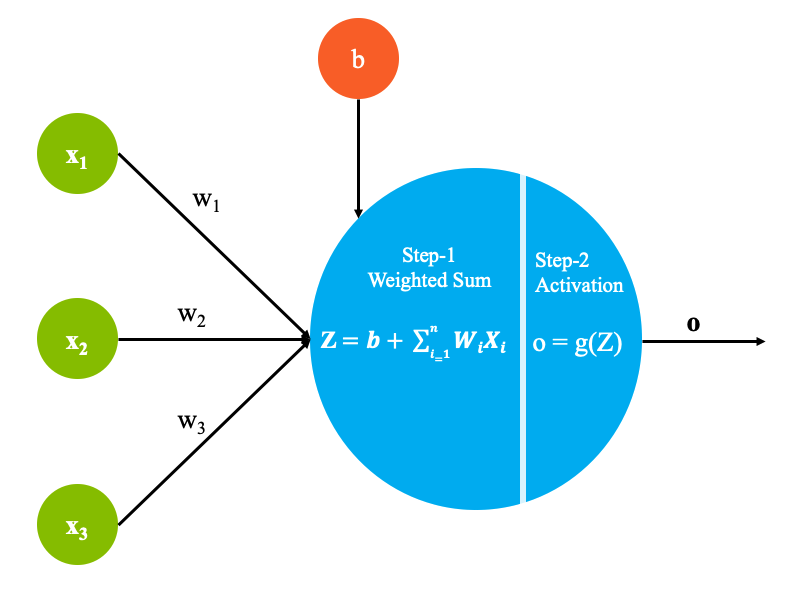
(Source: https://developer.ibm.com/articles/an-introduction-to-deep-learning/)

The information that pass into neuron are multiplied by a respective tunable weight, summed, and added by a tunable bias. Lastly, this "weighted sum" is passed into an activation function. The output of this activation function represents the final output of the neuron, and the input this neuron sends to the neurons in the next layer, if there is one.

These tunable variables are called "parameters," and adjusting their values through backpropagation is how an artificial nerual network can be trained.

### hyperbolic tangent (tanh) function

Passing the weighted sum through a non-linear activation function allows the composite of the network to encode knowledge of complex non-linear relationships.

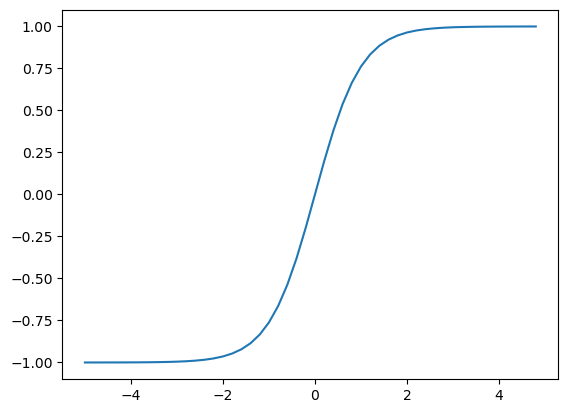

In [16]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid;

## Creating A Neuron

Below, we see how the formula for a neuron can be constructed and graphed with Value object computations

In [17]:
# Inputs: x1, x2
x1 = Value(2.0)
x2 = Value(0.0)

# Weights (modifiers)
w1 = Value(-3.0)
w2 = Value(1.0)

# Bias
b = Value(6.8813735870195432)

# Inputs get multiplied by weights in the neuron
x1w1 = x1 * w1
x2w2 = x2 * w2

# They then get added together
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = "x1*w1 + x2*w2"

# We then add the bias (this combination is called the cell body)
n = x1w1x2w2 + b

# Output (cell body passed through the neuron's activation function)
o = n.tanh()

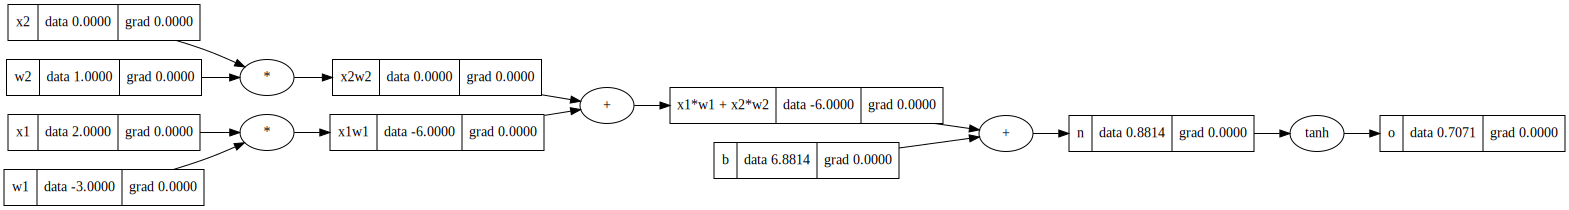

In [18]:
draw_dot(o)

## Manual Backpropagation on a Neuron

This is ostensibly the same process as performed on the generic Value multivariable expression, except now we are performing it on an expression that embodies the neuron formula.

In [19]:
# Setting the base case
o.grad = 1

In [20]:
# do/dn is the derivative of o with respect to n. o's relationship to n is o(n) = tanh(n). Therefore, do/dn equals:
# The derivative of tanh(n) = 1 - (tanh(x))^2
# tanh(n) = o

# So the gradient is: 1 - o^2:
1 - o.data**2

# 0.5

0.4999999999999999

In [21]:
n.grad = 0.5

In [22]:
b.grad = 0.5
x1w1x2w2.grad = 0.5

In [23]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [24]:
# Chain rule application
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

# 5: Implementing Automatic Backpropagation

## The \_backward Function

With this function implemented for each operation, we no longer have to manually calculate the partial derivatives and apply the chain rule. Now, we just need a way to call each of these \_backward functions automatically

In [25]:
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
w1._backward()
x1._backward()
x2._backward()
w2._backward()

## The backward() Function: Using Topolical Sort to call all _backward functions automatically on the whole expression

In [26]:
# Using a topological sort, we can organize the Value nodes from last to first
# This is necessary for proper execution order of backpropagation

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo

[Value(data = 6.881373587019543),
 Value(data = 1.0),
 Value(data = 0.0),
 Value(data = 0.0),
 Value(data = -3.0),
 Value(data = 2.0),
 Value(data = -6.0),
 Value(data = -6.0),
 Value(data = 0.8813735870195432),
 Value(data = 0.7071067811865476)]

In [27]:
#Manually set base case
o.grad = 1

#Sort the graph
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
        
build_topo(o)

# Call all the _backward functions through the topo array
for node in reversed(topo):
    node._backward()

In [28]:
# Implementing the above logic in an instance method in the Value class, we can now backpropagate in one call
o.backward()

# 6: Complex Graphs: Multiple Instances of the Same Variable in an Expression

In real nerual networks, it is common for a single variable to appear twice in the same expression. In these cases, the variable will affect the value in more than one operation, and will therefore have a unique gradient for each position in the expression. As such, the total effect of this variable on the expression will be the summation of the gradients of the variable for each location in the expression

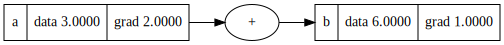

In [29]:
# Expression with the same variable used twice:

a = Value(3.0)
b = a + a #a is used twice in the partial expression that defines b

b.backward()
draw_dot(b)

In the above graph, imagine that there are 2 arrows pointing from 'a' into the addition, because a represents both the 'self' and the 'other' in this operation:

b = a + a

looking for the derivative of b with respect to a:

db/da = 1 + 1 = 2

Since each term of the expression is just a variable, the derivative for each term will be 1. So the final derivative adds to 2. 

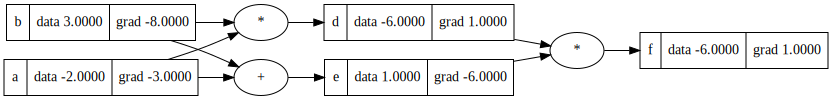

In [30]:
# More complex exmaple:

a = Value(-2.0)
b = Value(3.0)
d = a * b
e = a + b
f = d * e

f.backward()
draw_dot(f)

# In order for the gradients of a and b to be correct, the gradient from the multiplication and the addition must be added

## Bonus: Breaking Up Tanh into Smaller Operations

At this point, the Value object was updated to include operations for exponents, divison, and more atomic level operations as well as their necessary backpropagation functions.

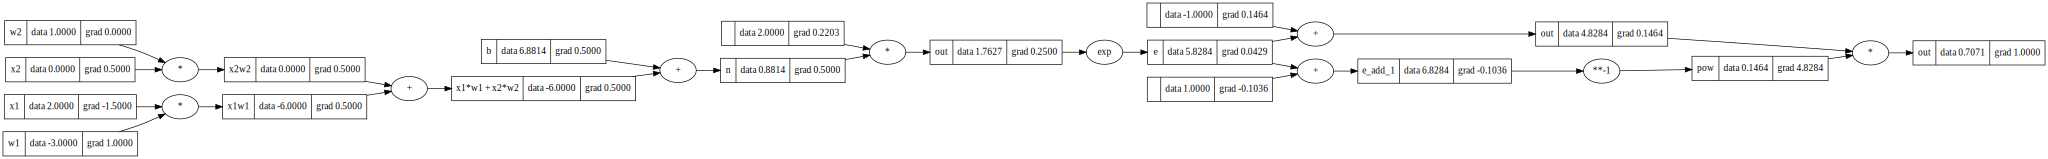

In [31]:
# Inputs: x1, x2
x1 = Value(2.0)
x2 = Value(0.0)

# Weights (modifiers)
w1 = Value(-3.0)
w2 = Value(1.0)

# Bias
b = Value(6.8813735870195432)

# Inputs get multiplied by weights in the neuron
x1w1 = x1 * w1
x2w2 = x2 * w2

# They then get added together
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = "x1*w1 + x2*w2"

# We then add the bias (this combination is called the cell body)
n = x1w1x2w2 + b

# Calculating the activation function, now broken up into smaller operations
e = (2*n).exp()
e_sub_1 = (e - 1)
e_add_1 = (e + 1)
o = e_sub_1 / e_add_1

## Backpropagating and displaying the expression
o.backward()
draw_dot(o)

## Intermission: Implementing what we've made in PyTorch -- It's the same

We have now learned the basic structure of a neural network as a mathematical expression, and have both learned and implemented the forward pass and backward pass (backpropagation) of a neural network. Now, let's do the same thing in a real Machine Learning library

In [32]:
import torch

x1 = torch.Tensor([2.0]).double()                 ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                 ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                 ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()   ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('___')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
___
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# 7: Creating a Neural Net Library in Micrograd

Now that the essential properties of the Value object have been defined and we have proven that Value objects can accurately represent a neuron's architecture and layers, we can formalize these structures into higher abstractions that wrap the value class.

These abstractions can be used to easily define the structure of arbitrary Multilayer Perceptrons.

In [33]:
import random

In [34]:
class Neuron:
    
    def __init__(self, nin): #nin = number of inputs
        # nin is the number of inputs going into the neuron
        # Create an array of weights initialized at random values, one for as many inputs the neuron takes
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        # Create a bias value for the neuron, initialized at a random value. This determines the neuron's trigger-happiness
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x): 
        # call just defines a function which is accessed through the variable name, making the object itself "callable"
        # in this case, we will define the object call to ...
        # w * x + b
        #where w * x is a dot product (I need to look into this because I currently lack the intuition)
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh() #act returns a Value object even though x is an int due to __mul__ and __rmul__ definitions
            #zip creates tuples out of corresponding elements in each set, and iterates over them! cool!
        return out
    
    ## Adding a "getter" method to retrieve a list of parameter data
    def parameters(self):
        return self.w + [self.b] #return the array of all input weights into the network plus the bias

class Layer:
    
    #nin = number of inputs for each neuron (dimensionality of neuron inputs, per neuron in the layer)
    #nout = number of neurons in the layer (aka, each output from the layer necessitates 1 neuron)
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        ## returns a concatinated list of all parameters from all neurons in the layer
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    #nin = number of inputs to the network (aka, the dataset!)
    #nouts = not how it sounds! It defines the size of each layer in the network after inputs! ex. [10, 10, 5, 10, 2]
    #the above list has a final output layer of 2, the outputs of the final layer represent the novel learned data!
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        ## returns a concatinated list of all the parameters from every layer in the network. All network parameters!
        return [p for layer in self.layers for p in layer.parameters()]

In [35]:
n = Neuron(2)
print('weights:', n.w)
print('bias:', n.b)

print('\n')

n2 = Neuron(4)
print('weights:', n2.w)
print('bias:', n2.b)

weights: [Value(data = -0.16688657449111832), Value(data = 0.06080404744649548)]
bias: Value(data = -0.8392783449864993)


weights: [Value(data = 0.03855468170404297), Value(data = 0.003602723426824328), Value(data = -0.1910210461382975), Value(data = -0.9083336723419735)]
bias: Value(data = -0.637439100603755)


## Using our MLP Library to Define our First Neural Nework (MLP)

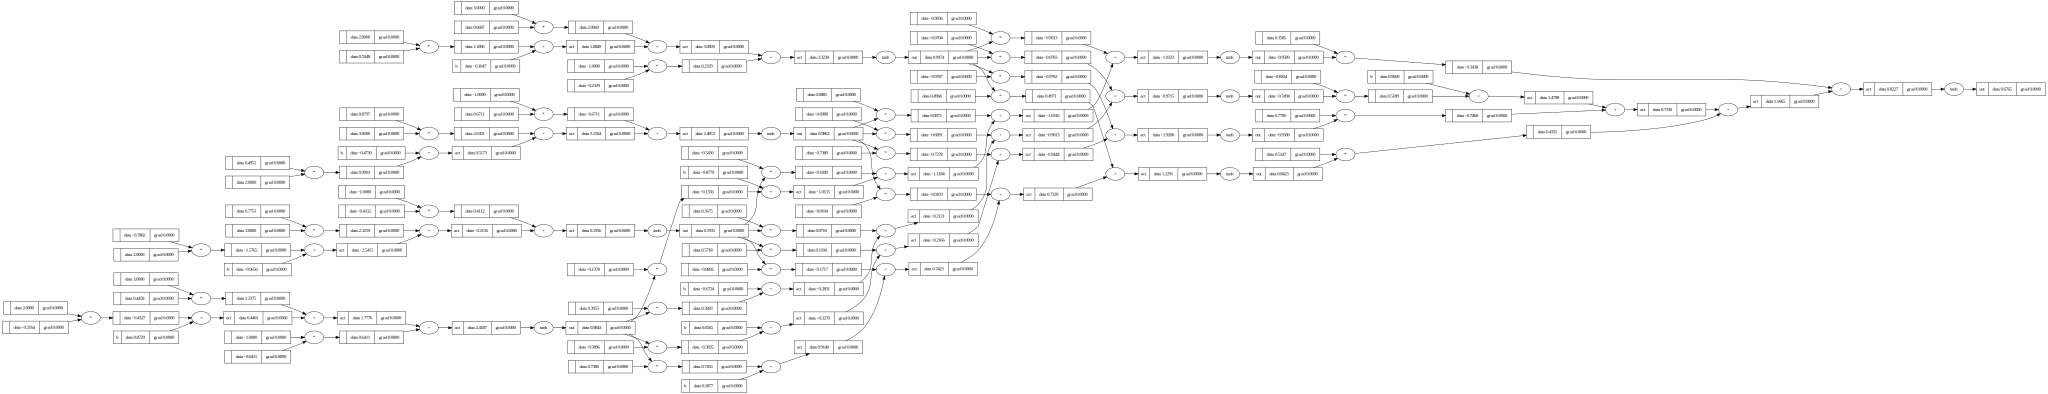

In [36]:
x = [2.0, 3.0, -1.0] # test dataset input
N = MLP(3, [4, 4, 1])
N(x)

draw_dot(N(x))

# 8: Example Dataset on Full MLP

Now that we've created our first MLP, let's train it on an arbitrary dataset.

We can do this by defining arbitrary input features, as well as an expected output from the network for each set of features.

In [37]:
#input dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
#desired (expected) outputs for each given input in set
ys = [1.0, -1.0, -1.0, 1.0]

#current prediction from the MLP
ypred = [N(x) for x in xs]
ypred

[Value(data = 0.6765468619877513),
 Value(data = 0.7897905420910843),
 Value(data = 0.7769051457352462),
 Value(data = 0.6761803322544103)]

Passing the input values into the MLP, we can see that the intial weights and biases result in an inaccurate prediction of outputs when compared to the expected outputs for this dataset.

However, now that the network has been designed to support backpropagation, allowing us to receive data on how the rate of change of each weight and bias may affect the cumulative output of the expression, we can now devise a function through which backpropagation is called in a way that will direct the network towards a set of weights and biases that generate a prediction that is desirable for a given set of inputs.

This is function is called a "loss" function, and will utilize the direction of gradient vectors in order to optimize the network for accurate predictions

# 9: Calculating and Interpreting Network Loss

## Mean Squared Error Loss

In [38]:
losses = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

loss = sum(losses) / len(losses)
loss

# Again, due to Value class operation callbacks, the final output of loss is a Value object, and thus maintains a connection
# to the larger computation graph

Value(data = 1.6425557978019822)

### Breaking it down

Above is the formula for Mean Squared Error Loss, a most simple loss function. This is where we represent the network error as a single scalar value with respect to which we can derive a gradient for each parameter in the network.

In this python implementation, we first zip the ys set, which in this case represents the "ground truth" output corresponding to the input dataset (ygt), with the yout set, which represents the network's prediction towards a "ground truth" for each input.

Now for each case, we simply subtract yout by ygt, giving us the difference between the prediction and the ground truth. To remove the sign and give us a positive "magnitude" of loss.

Why square the value? Technically you could also take the absolute value of the difference. Both work. Squaring will give an exponentially larger loss magnitude the larger the difference between yout and ygt.

Each element in this loss set is an individual loss component, relative to their respective network input. Next, the elements are summed and averaged in order to get a more accurate mean "loss" value for the network for any arbitrary input.

## Calling loss.backward()

Here's where the magic happens. Because the loss expression is a function with respect to the outputs of the neural network, the output of loss is represented as a Value object that can then backpropagate through all network forward passes that went into the loss function!

Now, all the gradients of every neuron from every forward pass are summed into the gradient values for every parameter stored in our MLP instance.

As such, we now how have the gradient vectors that tell us how the change in each parameter will affect the value of the loss function, guiding us towards how best to modify the network parameter values to achieve a loss value of near-zero.

In [39]:
loss.backward()
# N(x), after numerous internal calls, will ultimately output the final layer
# in this case, the final layer is a single output, and so when we call .backward() on the Network (N(x)), we are calling it
    # on the output.

# 10: Teaching the Network

## Getting the Parameters

Next, we need a way to apply this gradient information we have acquired to the parameters of our network. We will need to modify our MLP Library to include parameter retrieving functions so that we can then iterate through the all the parameters and augment them by their respective gradient multiplied by an arbitrary learning rate!

In [40]:
N.parameters() # After appying this modification, we can now call parameters() for access to all network parameters

[Value(data = -0.2163709584537683),
 Value(data = 0.4458293693984199),
 Value(data = -0.6410733414609131),
 Value(data = 0.8728827503910097),
 Value(data = -0.788235042859893),
 Value(data = 0.7752892549869115),
 Value(data = -0.41116389396828645),
 Value(data = -0.9650072292695615),
 Value(data = 0.49517285294906),
 Value(data = 0.8796862623565174),
 Value(data = 0.6711191579233662),
 Value(data = -0.47301189712752567),
 Value(data = 0.5947850307814961),
 Value(data = 0.6686582846230664),
 Value(data = -0.23292714618972665),
 Value(data = -0.10465018439366047),
 Value(data = 0.3955409829934806),
 Value(data = 0.3675324742236592),
 Value(data = -0.6987769965085993),
 Value(data = -0.07043395383051942),
 Value(data = -0.6724051361908885),
 Value(data = -0.38963291708608727),
 Value(data = 0.5717947972628943),
 Value(data = -0.7379706916573205),
 Value(data = -0.9787475921049531),
 Value(data = 0.05652606569582663),
 Value(data = 0.7379531452282422),
 Value(data = -0.8891773727365861),
 

N.parameters() will now return a list of all parameters in the MLP, which all contain their gradient within the value object.

In [41]:
len(N.parameters())

41

This is a quite small 41 parameter network

## Tuning the Parameters through Backpropagation

Let's look again at the loss of the network BEFORE we adjust the parameters in the direction of the gradient:

In [42]:
loss

Value(data = 1.6425557978019822)

After going through the following parameter adjustment, the new loss should be slighty lower:

In [43]:
# to automate learning, we need to iterate through all the parameters, add to the them the product of the
# gradient and the arbitrary learning rate and watch the loss converge towards zero!


for p in N.parameters():
    p.data += (p.grad * -0.01)
    #learning rate here is 0.5, and the sign is negative, as the gradient points in the directon of a greater loss value

In [44]:
ypred = [N(x) for x in xs]

losses = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
loss = sum(losses) / len(losses)

loss

Value(data = 1.6310327576180093)

And it was! We have taken the first step towards training this neural net.

## Automating the learning process

Now that all the steps of training a network have been defined, let's automate the learning process into an iterative learning cycle.

In [50]:
for k in range(5): ## Learning loop set to five iterations at a time
    
    #forward pass
    ypred = [N(x) for x in xs] # forward pass the network (make predictions)
    losses = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)] 
    loss = sum(losses) / len(losses)# calculate loss from forward pass predictions, connecting loss to the computation graph
    
    #backward pass
    loss.backward() #acquire gradients for network parameters with respect to the loss value
    
    #update parameters
    for p in N.parameters():
        p.data += (p.grad * -0.05) #update each parameter by the negative of the gradient vector and the learning rate
        #(1 step)
    
    #and repeat for as many arbitrary cycles as may be necessary to reach a near-zero loss

print("loss: " + str(loss.data))
print(ypred)

loss: 0.02834478336614933
[Value(data = 0.808241117759616), Value(data = -0.8811655668681005), Value(data = -0.8360739574241797), Value(data = 0.8112825005089185)]


And now we have our first trained MLP! With accurate predictions and low loss. Of course, because this MLP is completely arbitrary, it would be difficult to test it for overfitting.